In [6]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [7]:
%pip install torch_geometric
%pip install transformers

In [8]:
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from transformers import DebertaModel, DebertaTokenizer
import json
from tqdm import tqdm
import os
import csv
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

task_map = {}
task_list = []

with open('task.csv') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for i, row in enumerate(spamreader):
        if i:
            task_map[row[1]] = len(task_map)
            task_list.append(row[1])

arxiv_map = {}
ground_truth = []

path = "Data"

tokenizer = DebertaTokenizer.from_pretrained('Tokenizer')
model_bert = DebertaModel.from_pretrained('Encoder').to(device)

vectors = []
labels = []

for f in tqdm(os.listdir(path)):
    p = path + '/' + f
    with open(p, 'r', encoding='utf-8') as subFiles:
        subFiles = json.load(subFiles)
        label = [0 for _ in range(len(task_map))]
        flag = 0
        for i in subFiles['tasks']:
            if i['name'] in task_map:
                flag = 1
                label[task_map[i['name']]] = 1
        if flag:
            labels.append(label)
            arxiv_map[subFiles['id']] = len(arxiv_map)
            inputs = tokenizer(subFiles['abstract'].replace("\n", " ").strip(" "), return_tensors='pt', max_length=512, truncation=True).to(device)
            with torch.no_grad():
                outputs = model_bert(**inputs)
            vectors.append(outputs.last_hidden_state[0].mean(dim=0).cpu().numpy())

vectors = np.vstack(vectors)


with open('graph.json', 'r') as graph_file:
  graph_file = json.load(graph_file)
  edge_from = []
  edge_to = []
  for a, b in graph_file:
    if a in arxiv_map and b in arxiv_map:
      edge_from.append(arxiv_map[a])
      edge_to.append(arxiv_map[b])

edges = [edge_from, edge_to]


data = Data(x=torch.tensor(vectors), y=torch.tensor(labels, dtype=float), edge_index=torch.LongTensor(edges))

num_nodes = data.num_nodes
train_size = int(0.8 * num_nodes)
val_size = int(0.1 * num_nodes)

perm = torch.randperm(num_nodes)

data.train_mask = torch.zeros(num_nodes, dtype=bool)
data.val_mask = torch.zeros(num_nodes, dtype=bool)
data.test_mask = torch.zeros(num_nodes, dtype=bool)

data.train_mask[perm[:train_size]] = True
data.val_mask[perm[train_size:train_size+val_size]] = True
data.test_mask[perm[train_size+val_size:]] = True




100%|██████████| 930/930 [00:51<00:00, 17.97it/s] 


100%|██████████| 1000/1000 [00:08<00:00, 111.78it/s]


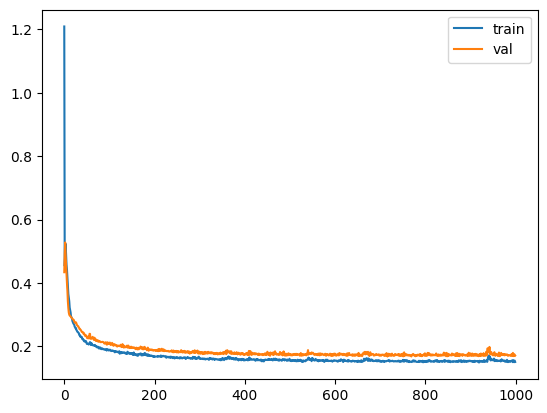

0.04264705882352941


In [9]:
from sklearn.metrics import f1_score, hamming_loss, jaccard_score



class Net(torch.nn.Module):
    def __init__(self, num_features, num_classes, task_list):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, 200)
        self.conv2 = GCNConv(200, num_classes)
        self.task_list = task_list

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def predict(self, data):
        result = []
        self.eval()
        logits = self(data)
        predicted = torch.greater(logits[0], 0.5).cpu()
        for i, task in enumerate(self.task_list):
          if predicted[i]:
            result.append(task)
        return result


num_features = vectors.shape[1]
num_classes = len(task_map)
model = Net(num_features, num_classes, task_list).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

data = data.to(device)
data.y = data.y.float()
train_loss = []
val_loss = []
for epoch in tqdm(range(1000)):
  model.train()
  optimizer.zero_grad()
  out = model(data)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  train_loss.append(loss.detach().item())
  model.eval()
  out = model(data)
  loss = criterion(out[data.val_mask], data.y[data.val_mask])
  val_loss.append(loss.detach().item())

model.eval()
out = model(data)
predicted = torch.greater(out[data.test_mask], 0.5).cpu()
truth = data.y[data.test_mask].cpu()

hamming = hamming_loss(predicted, truth)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

print(hamming)

torch.save(model, 'BGCN.pt')